In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Hypothesis
* Weather data significantly affect / correlate to palm oil production yield
* Palm oil industry related news sentiment significantly affect / correlate to CPO commodity prices

In [2]:
import os
os.getcwd()

'D:\\GitHub Repo\\WQD7005_DataMining\\Source Code\\03_DataModeling'

# Load Relevant Dataset

In [3]:
weather_df = pd.read_csv('../../B_Processed_Data/Processed_WeatherData.csv', index_col=0, parse_dates=True).reset_index()
station_dict = pd.read_csv('../../A_Raw_Data/WeatherData/Weather_WebCrawl/station_dict.csv')
news_df = pd.read_csv('../../B_Processed_Data/Processed_NewsData.csv')
production_df = pd.read_csv('../../B_Processed_Data/Processed_CPO_Production.csv')
price_df = pd.read_csv('../../B_Processed_Data/Processed_investing_Bursa_CPO_price.csv', index_col=0, parse_dates=True).reset_index()


__Weather Data__
* Weather data from 26 weather stations in Malaysia were selected.
* Data are crawled from <https://en.tutiempo.net>


In [4]:
# Select weather stations that are relevant
station_index=station_dict[station_dict.isna().any(axis=1)]['station_id'].unique()
weather_df = weather_df[weather_df['country']=='malaysia'].iloc[:, :-7]
weather_df.head()

,Day,country,location,station_id,latitude,longitude,T,TM,Tm,H,PP
290735,2015-10-01,malaysia,ALOR STAR,ws-486030,6.2,100.4,28.718182,35.172727,23.5,75.636364,4.410909
290736,2015-10-02,malaysia,ALOR STAR,ws-486030,6.2,100.4,28.718182,35.172727,23.5,75.636364,4.410909
290737,2015-10-03,malaysia,ALOR STAR,ws-486030,6.2,100.4,28.718182,35.172727,23.5,75.636364,4.410909
290738,2015-10-04,malaysia,ALOR STAR,ws-486030,6.2,100.4,28.718182,35.172727,23.5,75.636364,4.410909
290739,2015-10-05,malaysia,ALOR STAR,ws-486030,6.2,100.4,28.718182,35.172727,23.5,75.636364,4.410909


__News Data__
* News data crawled from <www.theedgemarkets.com> using 'Palm Oil' as search keyword.
* Sentiment Analysis will be performed on news title only

In [5]:
news_df.drop('news_content', axis=1, inplace=True)
news_df.head()

,news_title,news_date_update
0,"AirAsia X, Alliance, Berjaya Corp, CIMB, Desti...",29 February 2020
1,Sime Darby Plantation: COVID-19 has dried up p...,28 February 2020
2,Commodities savaged in sell-off as coronavirus...,28 February 2020
3,TDM gets RM210m offer for two loss-making Indo...,28 February 2020
4,"No planned divestment of MSM stake, says FGV",28 February 2020


__CPO Production Data__
* Monthly Malaysia CPO production from 2014 to 2020. Data Source: http://mpoc.org.my/monthly-palm-oil-trade-statistics-2014/

In [6]:
production_df.head()

,Month Year,Production
0,Jan 2019,1737461
1,Feb 2019,1544518
2,Mar 2019,1672058
3,Apr 2019,1649368
4,May 2019,1671467


__CPO Price MYR__
* Daily Trading Days CPO Prices on Bursa Malaysia market crawled from <https://investing.com>
* CPO price in MYR currency is used to minimize forex effects 

In [7]:
price_df = price_df.sort_values('Date')
price_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
1360,2014-08-18,2099.0,2105.0,2112.0,2096.0,1.04,-3.09
1359,2014-08-19,2074.0,2107.0,2107.0,2074.0,0.86,-1.19
1358,2014-08-20,2054.0,2078.0,2078.0,2051.0,0.56,-0.96
1357,2014-08-21,2055.0,2070.0,2070.0,2044.0,0.92,0.05
1356,2014-08-22,2021.0,2063.0,2063.0,2020.0,1.24,-1.65


# Data Wrangling 

__Rename Weather Data Day column to Date__

In [8]:
weather_df = weather_df.rename(columns={'Day':'Date'})

__Standardize Production monthly data timestamp and datatype__

In [9]:
production_df['Date'] = pd.to_datetime(production_df['Month Year'])
production_df = production_df.drop('Month Year', axis=1)
production_df.head()

,Production,Date
0,1737461,2019-01-01
1,1544518,2019-02-01
2,1672058,2019-03-01
3,1649368,2019-04-01
4,1671467,2019-05-01


__Convert date colume to correct datetime type__

In [10]:
news_df['Date'] = pd.to_datetime(news_df['news_date_update'])

__Remove any data prior to 2014 August for weather data and news data since our CPO price dataset only starts there__

In [11]:
weather_df = weather_df[weather_df['Date']>'2014-08']
production_df = production_df[production_df['Date']>'2014-08']
news_df = news_df[news_df['Date']>'2014-08']

# Exploration

### Let's first look at CPO PRICE

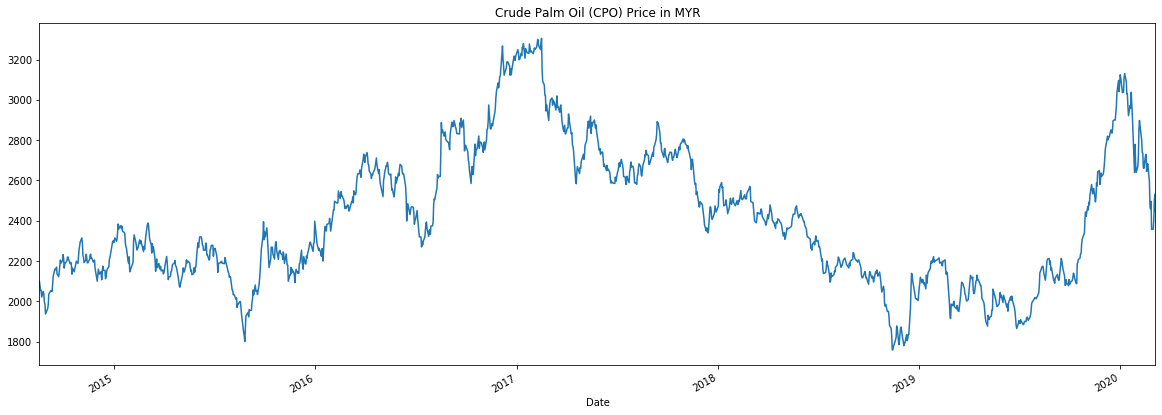

In [12]:
fig, ax = plt.subplots(figsize = (20,7))
price_df.set_index('Date')['Price'].plot(ax=ax)
plt.title('Crude Palm Oil (CPO) Price in MYR')
plt.show()

### Then  look at CPO Production

* CPO Production data seems seasonal with yearly dip near February

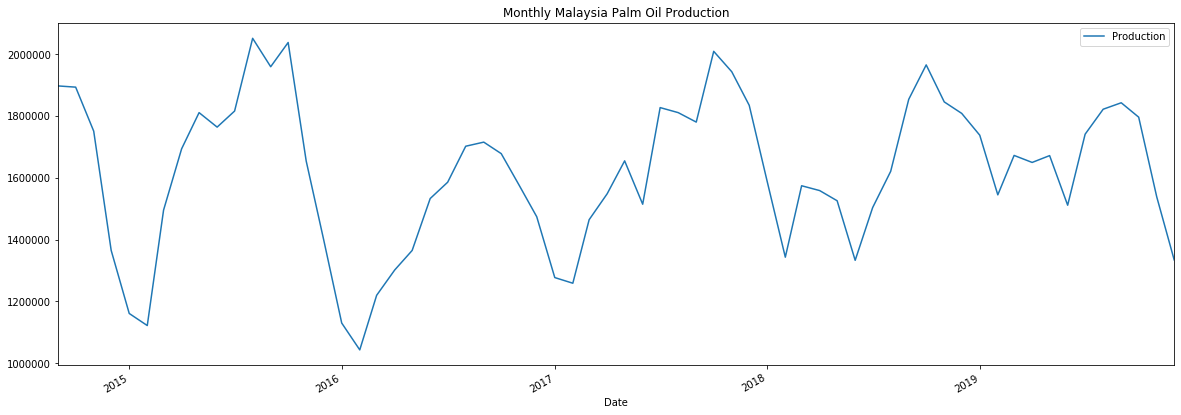

In [13]:
fig, ax = plt.subplots(figsize = (20,7))
production_df.set_index('Date').plot(ax=ax)
plt.title('Monthly Malaysia Palm Oil Production')
plt.show()

### And look at weather data
These are data from 106 weather stations in Malaysia, Indonesia and Singapore. We will only look at 5 main attributes:

    1) 'T' : 'Average Temperature (°C)'
    2) 'TM': 'Maximum temperature (°C)'
    3) 'Tm': 'Minimum temperature (°C)'
    4) 'H' : 'Average relative humidity (%)'
    5) 'PP': 'Total rainfall and / or snowmelt (mm)'

__PP: Total rainfall and / or snowmelt (mm)__
<br>The data for total rainfall is highly skewed with many centered around zero. We will need additional transformation to normalize this data

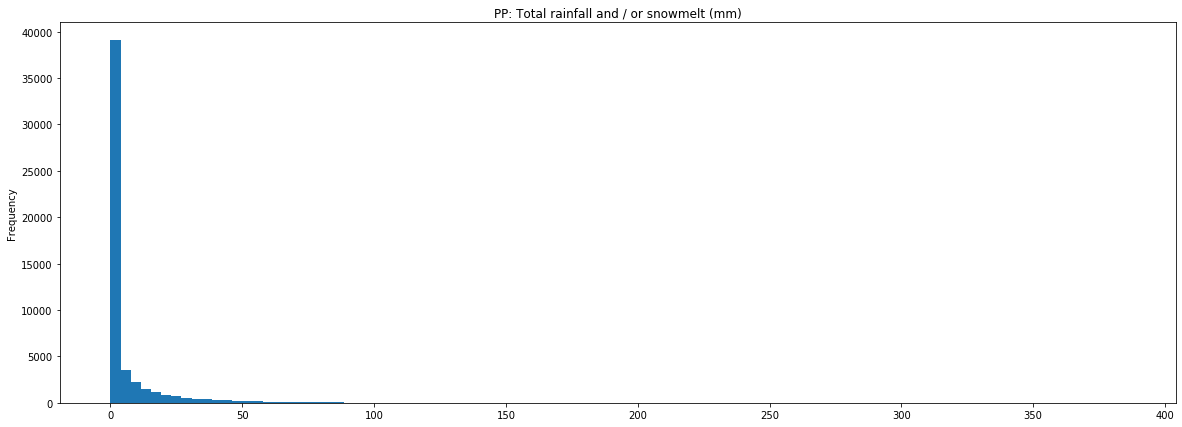

In [14]:
fig, ax = plt.subplots(figsize = (20,7))
weather_df['PP'].plot(kind='hist', bins=100, ax=ax)
plt.title('PP: Total rainfall and / or snowmelt (mm)')
plt.show()

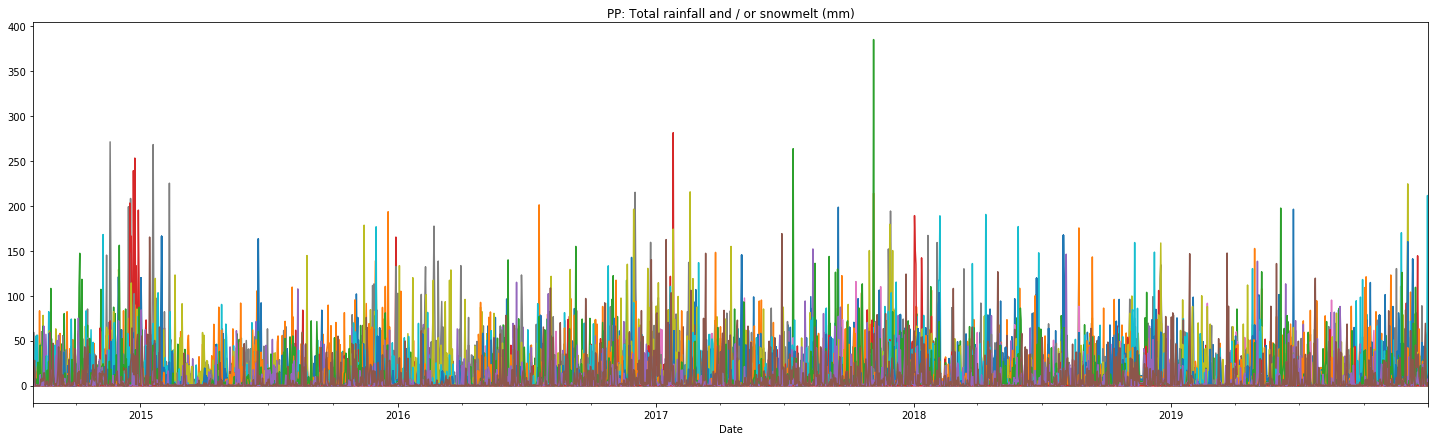

In [15]:
fig, ax = plt.subplots(figsize = (25,7))
weather_df.set_index('Date').groupby('station_id')['PP'].plot(ax=ax)
plt.title('PP: Total rainfall and / or snowmelt (mm)')
plt.show()

__Temperature Data__
* Temperature data looks reasonable for all weather stations.
* Seasonality can be observed

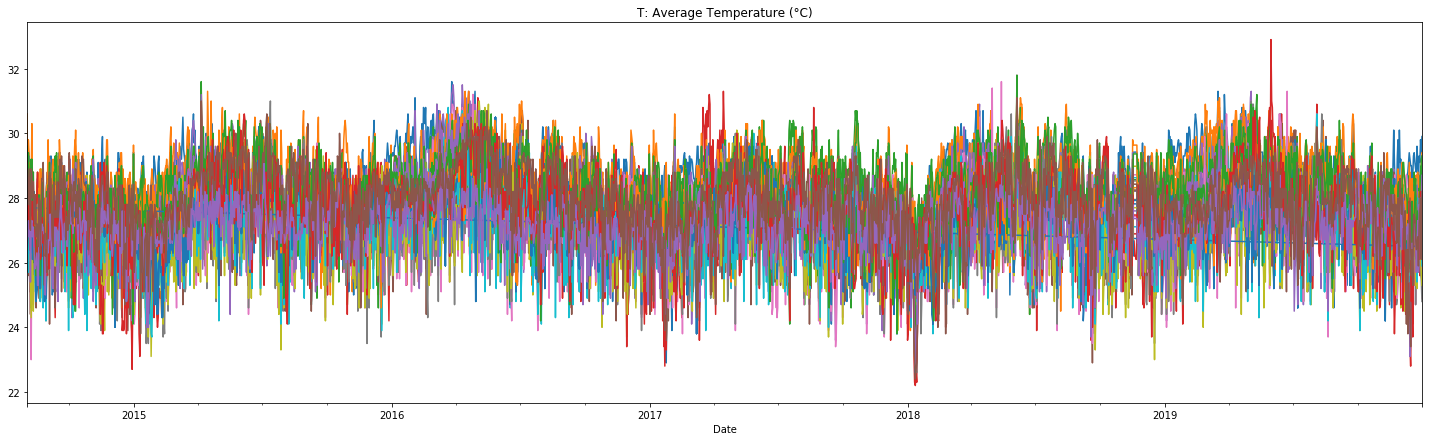

In [16]:
fig, ax = plt.subplots(figsize = (25,7))
weather_df.set_index('Date').groupby('station_id')['T'].plot()
plt.title('T: Average Temperature (°C)')
plt.show()

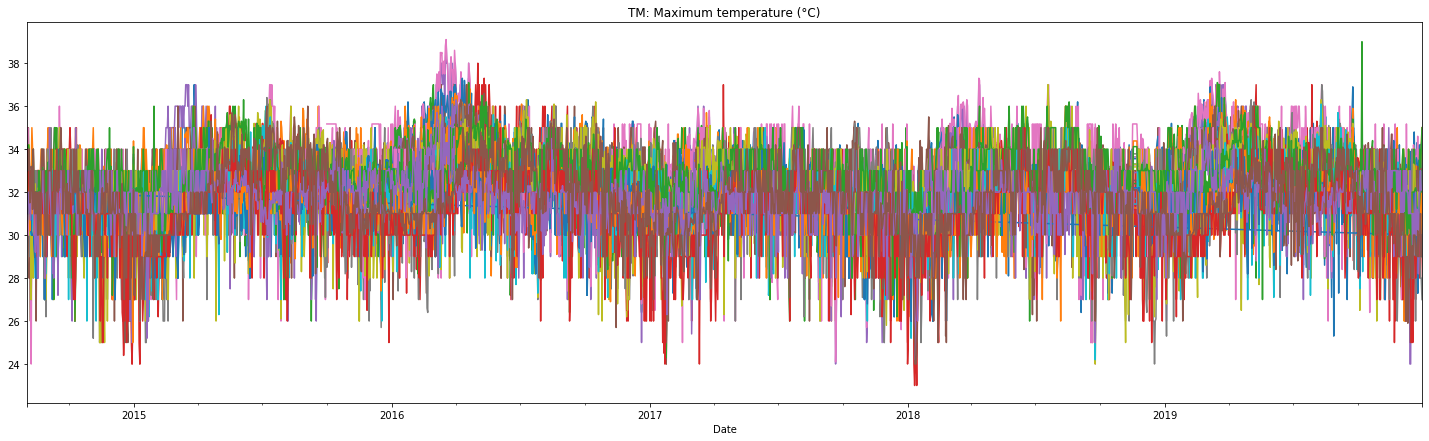

In [17]:
fig, ax = plt.subplots(figsize = (25, 7))
weather_df.set_index('Date').groupby('station_id')['TM'].plot()
plt.title('TM: Maximum temperature (°C)')
plt.show()

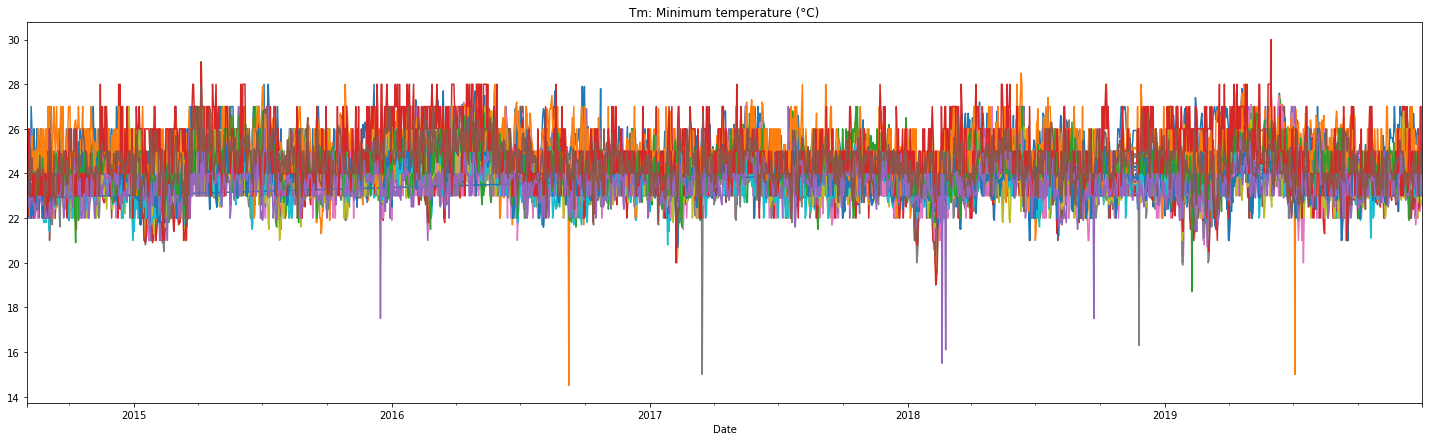

In [18]:
fig, ax = plt.subplots(figsize = (25, 7))
weather_df.set_index('Date').groupby('station_id')['Tm'].plot()
plt.title('Tm: Minimum temperature (°C)')
plt.show()

__H: Average relative humidity (%)'__
* Humidity looks reasonable with expected seasonality similarly seen from temperature data

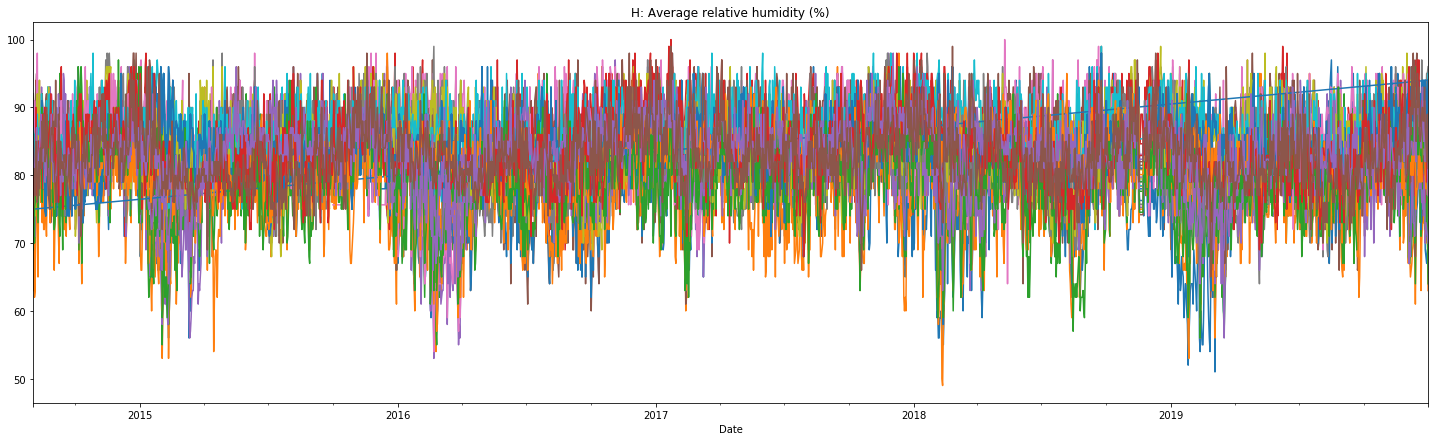

In [19]:
fig, ax = plt.subplots(figsize = (25,7))
weather_df.set_index('Date').groupby('station_id')['H'].plot()
plt.title('H: Average relative humidity (%)')
plt.show()

# Feature Transformation

## CPO Price
* We need to compute return in longer timeframe so to eliminate noise in daily price fluctuation
* Simple Moving Average or trend is computed to be used as a predictor since CPO prices are affected by other wordly components and should be factored into the trend.

__Compute CPO Price Simple Moving Average as a feature__

In [20]:
price_df['Price_MAV5'] = price_df['Price'].rolling(5, min_periods=1).mean()
price_df['Vol_MAV5'] = price_df['Vol.'].rolling(5, min_periods=1).mean()
price_df['Change_MAV5'] = price_df['Change %'].rolling(5, min_periods=1).mean()
price_df['Price_MAV10'] = price_df['Price'].rolling(10, min_periods=1).mean()
price_df['Vol_MAV10'] = price_df['Vol.'].rolling(10, min_periods=1).mean()
price_df['Change_MAV10'] = price_df['Change %'].rolling(10, min_periods=1).mean()

In [21]:
price_df.dropna(inplace=True)
price_df = price_df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
price_df.head()

,Date,Price,Price_MAV5,Vol_MAV5,Change_MAV5,Price_MAV10,Vol_MAV10,Change_MAV10
1360,2014-08-18,2099.0,2099.000000,1.040,-3.090000,2099.000000,1.040,-3.090000
1359,2014-08-19,2074.0,2086.500000,0.950,-2.140000,2086.500000,0.950,-2.140000
1358,2014-08-20,2054.0,2075.666667,0.820,-1.746667,2075.666667,0.820,-1.746667
1357,2014-08-21,2055.0,2070.500000,0.845,-1.297500,2070.500000,0.845,-1.297500
1356,2014-08-22,2021.0,2060.600000,0.924,-1.368000,2060.600000,0.924,-1.368000


## CPO Production

__Create feature for monthly production change__

In [22]:
production_df = production_df.sort_values('Date')
production_df['production_change'] = production_df['Production'].diff()
production_df['Month'] = production_df['Date'].dt.month

## Weather Data

* It looks like all the weather data except PP are correlated, but not too strongly around value of 0.6- 0.7

__Scale column 'PP' in weather data using log(x+1)__
* This will make larger values smaller since models perform better with small values. 

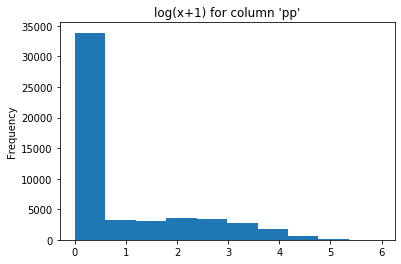

In [23]:
weather_df['PP'] = weather_df['PP'].apply(lambda x: math.log(x+1))
weather_df['PP'].plot(kind='hist')
plt.title("log(x+1) for column 'pp'")
plt.show()

__Visualize Weather Data__

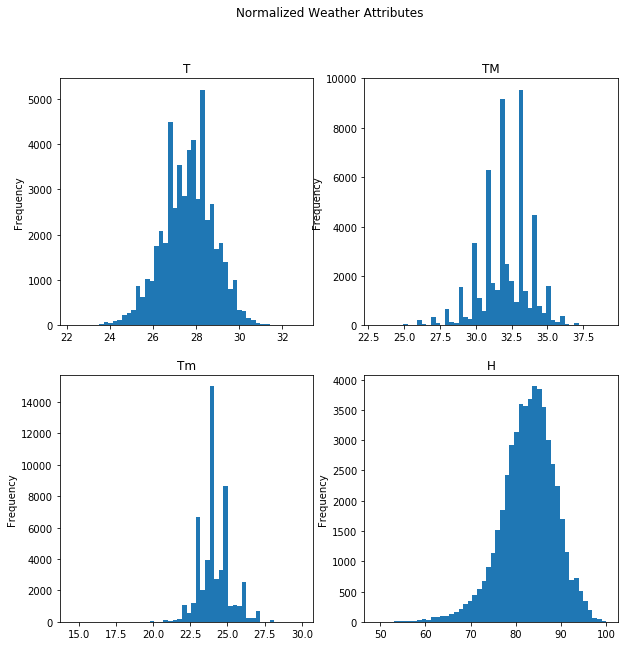

In [24]:
w_attributes = weather_df.iloc[:,-5:-1].columns
fig, ax = plt.subplots(2, 2, figsize=(10,10))
r=0
for i, col in enumerate(w_attributes, 0):
    r = i//2
    c = i%2
    weather_df[col].plot(kind='hist', bins=50, ax=ax[r, c])
    ax[r, c].set_title(col)
plt.suptitle('Normalized Weather Attributes')    
plt.show()

,T,TM,Tm,H,PP
T,1.000000,0.689962,0.605666,-0.692628,-0.305085
TM,0.689962,1.000000,0.224852,-0.569812,-0.260605
Tm,0.605666,0.224852,1.000000,-0.229207,-0.255081
H,-0.692628,-0.569812,-0.229207,1.000000,0.298786
PP,-0.305085,-0.260605,-0.255081,0.298786,1.000000


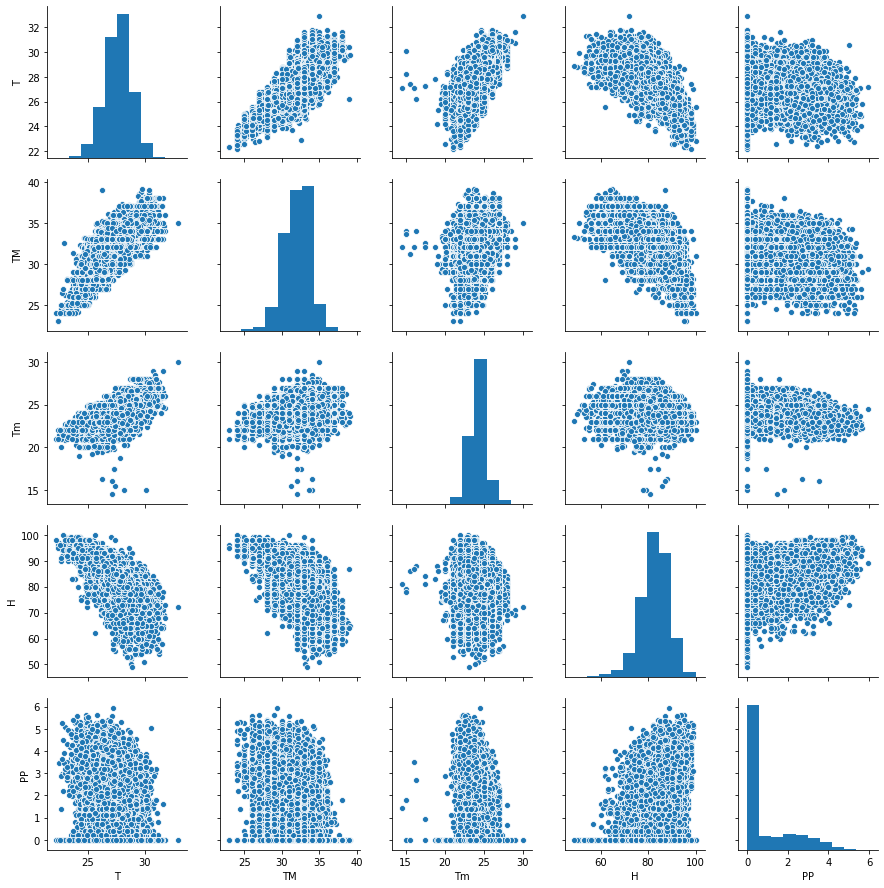

In [25]:
display(weather_df.iloc[:,-5:].corr())
sns.pairplot(weather_df.iloc[:,-5:])

__Pivot tables on Weather Data using only T, H and PP__

In [26]:
weather_df.set_index('Date', inplace=True)
weather_monthly_df = weather_df.groupby([weather_df.index.year.rename('year'), weather_df.index.month.rename('month'), 'station_id']).agg({'T':'mean', 'TM':'mean', 'Tm':'mean', 'H':'mean', 'PP':'sum'})
weather_monthly_df.reset_index(inplace=True)
weather_monthly_df['Date'] = pd.to_datetime(weather_monthly_df.apply(lambda x: str(x.year)+'-'+str(x.month), axis=1))
weather_pivot_df = weather_monthly_df.reset_index().pivot_table(index=['Date'], values=['T', 'H', 'PP'], columns='station_id').ffill().bfill(0)
weather_pivot_df.columns = ['_'.join(col) for col in weather_pivot_df.columns.values]

weather_pivot_df.head()

,H_ws-486000,H_ws-486010,H_ws-486020,H_ws-486021,H_ws-486022,H_ws-486023,H_ws-486030,H_ws-486150,H_ws-486180,H_ws-486200,...,T_ws-960011,T_ws-964130,T_ws-964210,T_ws-964410,T_ws-964490,T_ws-964650,T_ws-964710,T_ws-964770,T_ws-964810,T_ws-964910
Date,,,,,,,,,,,,,,,,,,,,,
2014-08-01,85.166667,83.766667,84.366667,87.700000,86.733333,79.233333,80.803519,82.300000,82.000000,83.466667,...,26.140000,26.650000,26.036667,26.180000,26.623333,27.550000,27.313333,26.840000,26.516667,27.656667
2014-09-01,86.400000,82.766667,85.300000,84.666667,86.900000,79.933333,80.803519,80.466667,83.533333,83.000000,...,27.130000,27.170000,26.886667,26.846667,27.676667,28.316667,28.066667,27.360000,26.780000,27.966667
2014-10-01,87.870968,83.580645,84.838710,83.580645,86.709677,83.806452,80.803519,85.354839,87.354839,84.064516,...,26.674194,26.922581,26.429032,26.419355,27.603226,27.706452,27.209677,26.890323,27.190323,28.038710
2014-11-01,83.700000,83.666667,84.466667,86.900000,85.033333,85.766667,80.803519,89.633333,88.366667,86.433333,...,26.470000,26.573333,26.306667,26.366667,27.590000,27.996667,27.840000,27.396667,26.900000,27.663333
2014-12-01,81.428152,81.979472,86.504399,87.800587,84.428152,88.425220,80.803519,86.935484,84.530792,86.788856,...,26.310557,26.552493,26.306452,26.368035,27.058944,27.616716,27.292375,26.715249,26.860117,27.555718


## News Data
* From the visualization we can see 'Compound' is computed using 'negative' and 'positive' sentiment attributes.

__Perform sentiment analysis using VaderSentiment__
<br>1) We need to infer sentiment value on news titles. In order to do this we will use VaderSentiment

In [27]:
# !pip install vaderSentiment

In [28]:
# Use VaderSentiment to perform sentiment analysis on news title
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
vader_df = pd.DataFrame([row for row in news_df['news_title'].apply(lambda x: analyzer.polarity_scores(x))])


# Concat date with result, and aggregate mean sentiment score by date
sentiment_df = pd.concat([news_df[['Date','news_title']], vader_df], axis=1)
sentiment_df.head()

,Date,news_title,neg,neu,pos,compound
0,2020-02-29,"AirAsia X, Alliance, Berjaya Corp, CIMB, Desti...",0.000,1.000,0.0,0.0000
1,2020-02-28,Sime Darby Plantation: COVID-19 has dried up p...,0.120,0.880,0.0,-0.1280
2,2020-02-28,Commodities savaged in sell-off as coronavirus...,0.492,0.508,0.0,-0.7003
3,2020-02-28,TDM gets RM210m offer for two loss-making Indo...,0.000,1.000,0.0,0.0000
4,2020-02-28,"No planned divestment of MSM stake, says FGV",0.239,0.761,0.0,-0.2960


__Check Sentiment Result__
Following news title make sense to have a negative sentiment

In [29]:
print(sentiment_df['news_title'].iloc[780])
print(sentiment_df[['neg', 'neu', 'pos', 'compound']].iloc[780])

EU palm oil ban is Indonesia’s concern for Axiata-Telenor merger
neg         0.2860
neu         0.7140
pos         0.0000
compound   -0.5574
Name: 780, dtype: float64


__Group sentiment by Date and mean aggregate the sentiment__

In [30]:
sentiment_df = sentiment_df.groupby('Date').mean().rolling(5, min_periods=1).sum()
sentiment_df.head()

,neg,neu,pos,compound
Date,,,,
2014-08-25,0.000000,1.000000,0.000000,0.000000
2014-08-29,0.352000,1.437000,0.211000,-0.446600
2014-09-02,0.643000,2.146000,0.211000,-1.018500
2014-09-03,0.798000,2.991000,0.211000,-1.314500
2014-09-04,0.872429,3.775857,0.351714,-1.216314


__Visualize sentiment attributes__

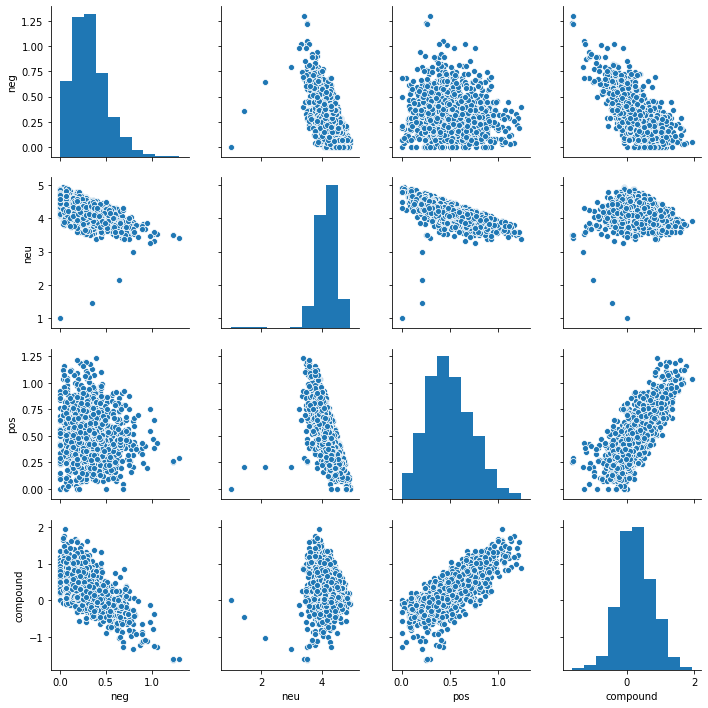

In [31]:
sns.pairplot(sentiment_df)

# Merge all data into respective dataframes
We have two sets of merge dataframes here
* merge_df is the dataframe prepared for modelling CPO prices using news sentiment, CPO previous price action and CPO production
* merge_df2 is the dataframe prepared for modelling CPO production using weather data

## Dataframe 1
__Merge CPO Price with CPO_production and News Sentiment__

In [32]:
# Merge and shift 1 month on CPO production to account for the report that usually come at the end of month
merge_df = pd.merge(price_df, production_df.drop(['Production', 'Month'], axis=1).shift(1), how='outer', on='Date')
merge_df = merge_df[(merge_df['Date']<'2020') & (merge_df['Date']>='2014-11')].sort_values('Date')

# Forward Fill Production Change Data
merge_df['production_change'] = merge_df['production_change'].ffill()

merge_df['month'] = merge_df['Date'].dt.month
merge_df['dayofweek'] = merge_df['Date'].dt.dayofweek

# Drop rows where price is NA due to the merge
merge_df = merge_df[~merge_df['Price'].isna()]

# Smooth out the production data using rolling mean of 10 periods
merge_df['production_change'] = merge_df['production_change'].rolling(10, min_periods=1).mean()


merge_df.head()

,Date,Price,Price_MAV5,Vol_MAV5,Change_MAV5,Price_MAV10,Vol_MAV10,Change_MAV10,production_change,month,dayofweek
51,2014-11-03,2315.0,2273.4,0.404,1.134,2224.5,0.512,0.674,-142429.0,11,0
52,2014-11-04,2285.0,2286.0,0.204,0.564,2238.3,0.502,0.627,-142429.0,11,1
53,2014-11-05,2228.0,2279.6,0.116,-0.276,2245.2,0.475,0.322,-142429.0,11,2
54,2014-11-06,2219.0,2268.4,0.090,-0.488,2248.6,0.391,0.162,-142429.0,11,3
55,2014-11-07,2192.0,2247.8,0.102,-0.908,2247.9,0.357,-0.024,-142429.0,11,4


In [33]:
# Merge the same dataframe to news sentiment
merge_df = pd.merge(merge_df, sentiment_df, how='left', on='Date')

# forward fill the sentiment if any na
merge_df[['neg', 'neu', 'pos', 'compound']] = merge_df[['neg', 'neu', 'pos', 'compound']].ffill()
merge_df.head()

,Date,Price,Price_MAV5,Vol_MAV5,Change_MAV5,Price_MAV10,Vol_MAV10,Change_MAV10,production_change,month,dayofweek,neg,neu,pos,compound
0,2014-11-03,2315.0,2273.4,0.404,1.134,2224.5,0.512,0.674,-142429.0,11,0,0.151107,4.416191,0.432702,0.356207
1,2014-11-04,2285.0,2286.0,0.204,0.564,2238.3,0.502,0.627,-142429.0,11,1,0.223964,4.286048,0.489987,0.376678
2,2014-11-05,2228.0,2279.6,0.116,-0.276,2245.2,0.475,0.322,-142429.0,11,2,0.394964,4.067207,0.537829,0.187735
3,2014-11-06,2219.0,2268.4,0.090,-0.488,2248.6,0.391,0.162,-142429.0,11,3,0.422798,4.063607,0.513595,0.115329
4,2014-11-07,2192.0,2247.8,0.102,-0.908,2247.9,0.357,-0.024,-142429.0,11,4,0.432898,4.079007,0.488095,0.052602


## Dataframe 2
__Merge CPO Production data with Weather Data__

In [34]:
merge_df2 = pd.merge(production_df.drop('Production', axis=1), weather_pivot_df, how='left', on='Date').dropna()
merge_df2.head()

,Date,production_change,Month,H_ws-486000,H_ws-486010,H_ws-486020,H_ws-486021,H_ws-486022,H_ws-486023,H_ws-486030,...,T_ws-960011,T_ws-964130,T_ws-964210,T_ws-964410,T_ws-964490,T_ws-964650,T_ws-964710,T_ws-964770,T_ws-964810,T_ws-964910
1,2014-10-01,-3903.0,10,87.870968,83.580645,84.838710,83.580645,86.709677,83.806452,80.803519,...,26.674194,26.922581,26.429032,26.419355,27.603226,27.706452,27.209677,26.890323,27.190323,28.038710
2,2014-11-01,-142429.0,11,83.700000,83.666667,84.466667,86.900000,85.033333,85.766667,80.803519,...,26.470000,26.573333,26.306667,26.366667,27.590000,27.996667,27.840000,27.396667,26.900000,27.663333
3,2014-12-01,-385770.0,12,81.428152,81.979472,86.504399,87.800587,84.428152,88.425220,80.803519,...,26.310557,26.552493,26.306452,26.368035,27.058944,27.616716,27.292375,26.715249,26.860117,27.555718
4,2015-01-01,-204110.0,1,70.322581,72.354839,76.290323,81.032258,72.032258,80.741935,80.803519,...,25.506452,25.583871,25.370968,25.319355,26.048387,27.141935,27.103226,26.777419,26.280645,26.622581
5,2015-02-01,-39059.0,2,68.357143,68.857143,71.964286,79.857143,68.107143,73.678571,80.803519,...,26.428571,25.939286,25.742857,25.957143,26.057143,27.353571,27.275000,27.078571,26.960714,27.278571


# 1) Modeling for CPO Price
* We use a simple neural network constructed from tensorflow and keras Sequential API.

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_absolute_error

RANDOM_STATE=123

In [38]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(8,8))
    plt.plot(np.arange(len(loss)), loss ,label='train')
    plt.plot(np.arange(len(loss)), val_loss ,label='validation')
    plt.legend()
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('MAE')
    plt.show()

## Partition Dataset

In [39]:
TRAIN_SPLIT= int(len(merge_df)*(1-0.33))
attributes= ['Price', 'month', 'dayofweek', 'Price_MAV5', 'Price_MAV10', 'Vol_MAV5', 'Vol_MAV10', 'Change_MAV5', 'Change_MAV10', 'production_change', 'pos', 'neu', 'neg', 'compound']
multi_data = merge_df.loc[:,attributes]
tf.random.set_seed(RANDOM_STATE)

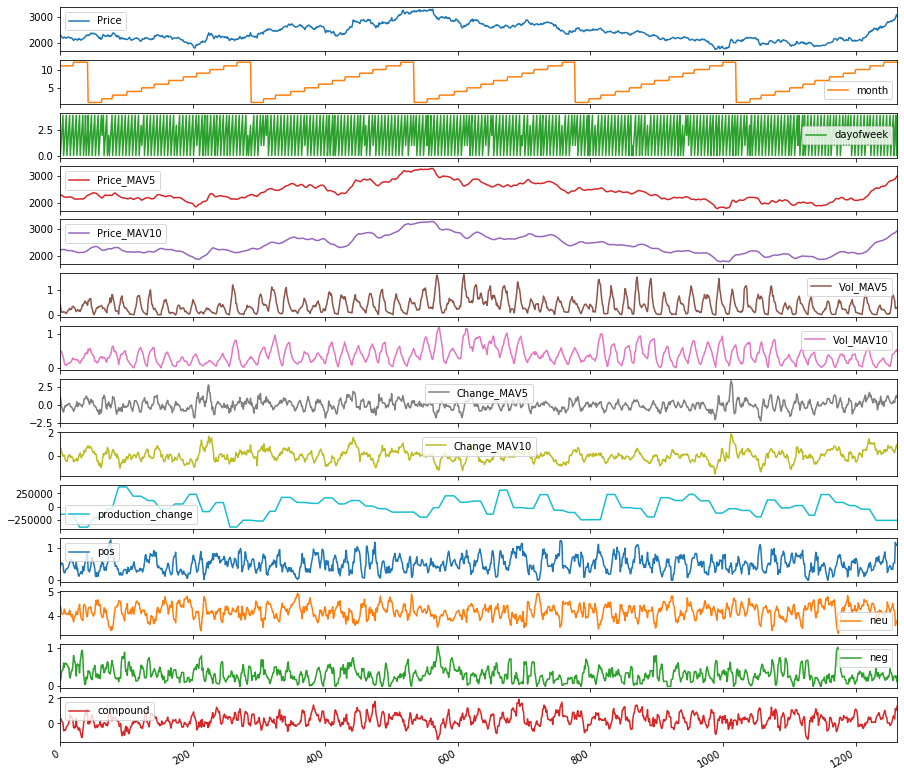

In [40]:
multi_data.plot(subplots=True, figsize=(15,15))
plt.show()

__Normalize Dataset__

In [41]:
dataset = multi_data.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

# standardize data
dataset = (dataset-data_mean)/data_std

## LSTM
* We use history window of 20 trading days to predict the next day CPO price

In [42]:
past_history = 20
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (20, 14)


In [43]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [44]:
tf.keras.backend.clear_session()
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(64, input_shape=x_train_single.shape[-2:], recurrent_dropout=0.5, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, kernel_initializer='he_normal'))
single_step_model.add(tf.keras.layers.Dropout(0.3))
single_step_model.add(tf.keras.layers.Dense(1, activation='linear'))


In [45]:
EVALUATION_INTERVAL = 15
EPOCHS = 65
single_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae'])
history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data_single,
                                validation_steps=100, verbose=0)

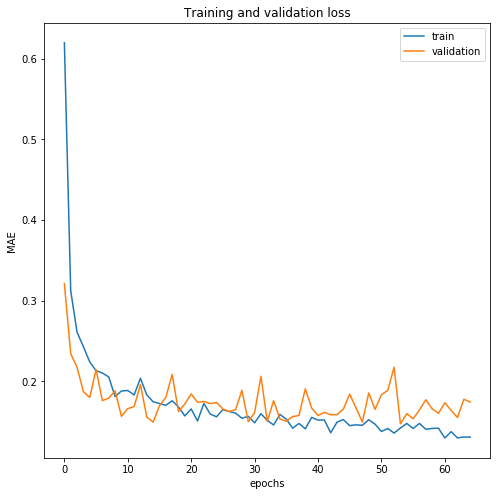

Training MAE Loss: 0.13092975318431854
Validation MAE Loss: 0.17445853352546692


In [91]:
plot_loss(history)
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print(f'Training MAE Loss: {train_loss}\nValidation MAE Loss: {val_loss}')

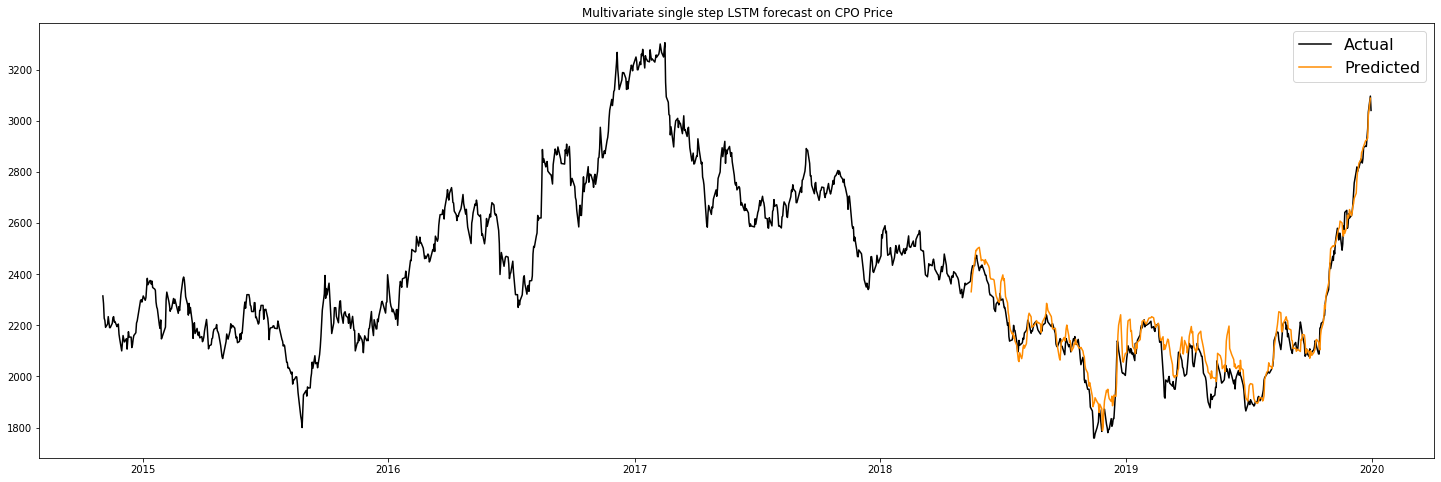

In [47]:
plt.figure(figsize=(25,8))
y_pred = pd.Series(single_step_model.predict(x_val_single).flatten(), index=merge_df[TRAIN_SPLIT+20:-1].loc[:,'Date']).rename('Predicted')
y_pred = (y_pred*data_std[0])+data_mean[0]
plt.plot(merge_df[['Date','Price']].set_index('Date'), label='Actual', color='black')
plt.plot(y_pred.index, y_pred, label='Predicted', color = 'darkorange')
plt.legend(fontsize=16)
plt.title('Multivariate single step LSTM forecast on CPO Price')
plt.show()

## Feature importance using feature pertubation
* Each attribute will be replace by zero and see their effects on the final prediction metric, MAE is used here
* Baseline MAE is 0.174 as gotten from the last model prediction

__Top Feature__
* Price: LSTM prediction is based mostly on the price itself, along with it's moving average 5 and 10
* The rest of the features can be considered unimportant as they have very little effect on the result. 

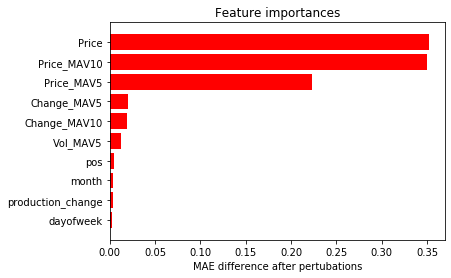

In [117]:
pertub_mae = []
for i in range(x_val_single.shape[-1]):
    pertub_x = x_val_single.copy()
    pertub_x[:,:,i] = 0
    y_pertub_pred = single_step_model.predict(pertub_x)
    pertub_mae.append(mean_absolute_error(y_pertub_pred, y_val_single)-val_loss)
    
indices = np.argsort(pertub_mae)[-10:]
plt.figure()
plt.title("Feature importances")
plt.barh(range(10), np.asarray(pertub_mae)[indices], color="r", align="center")
plt.xlabel('MAE difference after pertubations')
plt.yticks(range(10), np.asarray(attributes)[indices])
plt.ylim([-1, 10])
plt.show()

# 2) Modelling for CPO Production
* CPO Production Monthly data is only available since 2014 with a total of 63 observation.
* This is quite a limited sample size to work with, thus we are using only simple regressor here for the task

__Normalize dataset__

In [60]:
scaler2 = StandardScaler()
final_df2 = merge_df2.copy().set_index('Date')
scale_columns=set(final_df2.columns)-set(['Date','Month'])
final_df2.loc[:, scale_columns] = scaler.fit_transform(final_df2.loc[:, scale_columns])
final_df2.head()

,production_change,Month,H_ws-486000,H_ws-486010,H_ws-486020,H_ws-486021,H_ws-486022,H_ws-486023,H_ws-486030,H_ws-486150,...,T_ws-960011,T_ws-964130,T_ws-964210,T_ws-964410,T_ws-964490,T_ws-964650,T_ws-964710,T_ws-964770,T_ws-964810,T_ws-964910
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,0.030150,10,1.329513,1.091198,0.977366,-0.214786,0.677108,1.005206,-0.457621,1.005878,...,-0.540372,-0.317654,-0.844921,-1.201823,0.215686,-0.480275,-1.341313,-1.098954,0.183639,0.150116
2014-11-01,-0.799624,11,0.627500,1.111526,0.881910,0.907989,0.390689,1.493944,-0.457621,2.233513,...,-0.971183,-0.961793,-1.078841,-1.299032,0.192400,0.047836,-0.323795,-0.322283,-0.627051,-0.455833
2014-12-01,-2.257243,12,0.245127,0.712819,1.404735,1.212613,0.287288,2.156796,-0.457621,1.459415,...,-1.307579,-1.000231,-1.079252,-1.296507,-0.742606,-0.643570,-1.207815,-1.367495,-0.738418,-0.629550
2015-01-01,-1.169095,1,-1.624044,-1.561611,-1.215909,-1.076780,-1.830663,0.241136,-0.457621,0.422759,...,-3.004096,-2.786724,-2.867563,-3.231306,-2.521849,-1.507537,-1.513156,-1.272134,-2.356523,-2.135862
2015-02-01,-0.180435,2,-1.954845,-2.388163,-2.325848,-1.474264,-2.501304,-1.519961,-0.457621,-0.622822,...,-1.058590,-2.131209,-2.156643,-2.054597,-2.506434,-1.122419,-1.235864,-0.810203,-0.457514,-1.076933


## Partition Dataset

In [61]:
X = final_df2.iloc[:,1:]
y = final_df2.iloc[:,0]

## Models
* Support Vector Regressor
* Random Forest Regressor
* KNeighbors Regressor
* Voting Regressor comprising of above three regressors

In [62]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer

In [63]:
svr = SVR(gamma='auto')
rf = RandomForestRegressor(n_estimators=100, max_depth=5)
knn = KNeighborsRegressor()
vote = VotingRegressor([('svr', svr), ('rf', rf), ('knn', knn)])

## Train and Evaluate Model using 5-Fold Cross Validation

In [64]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
RANDOM_STATE = 123
N_SPLITS = 5

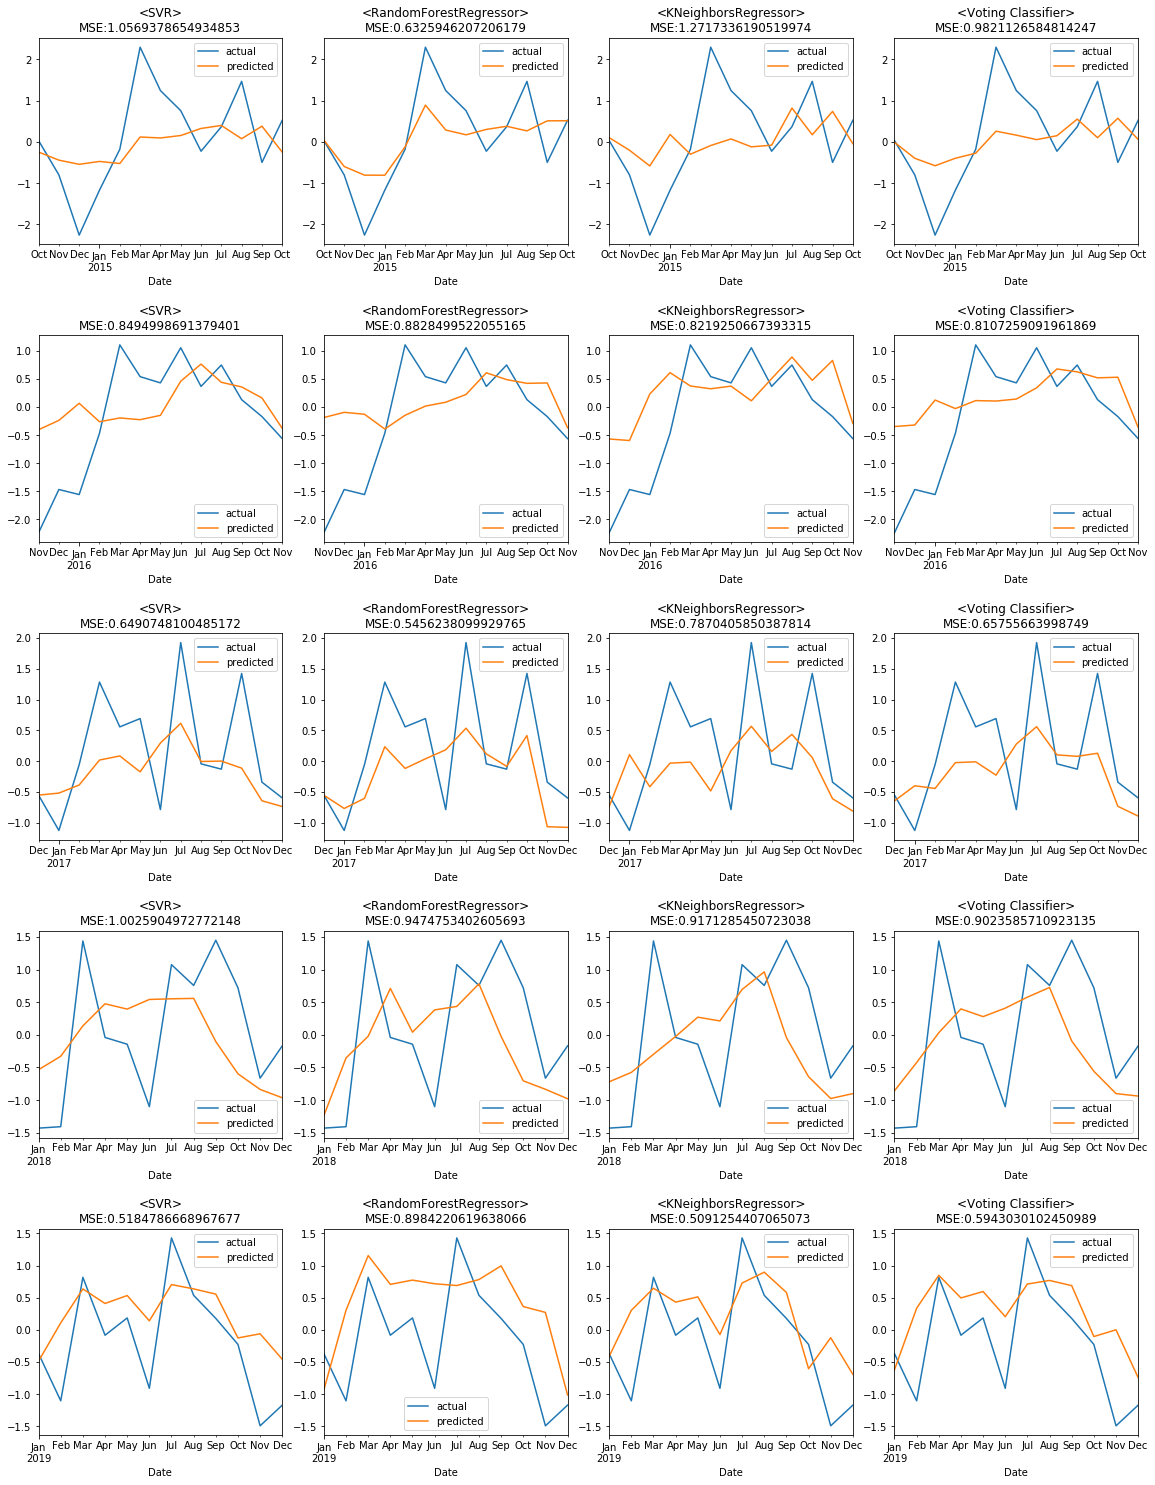

In [65]:
fit, ax = plt.subplots(N_SPLITS, 4, figsize=(16,4*N_SPLITS))
plt.tight_layout(h_pad=7)
kf = KFold(n_splits=N_SPLITS, shuffle=False)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    for j, clf in enumerate([svr, rf, knn]):
        clf.fit(X_train, y_train)
        y_pred_clf = clf.predict(X_test)
    
        mse = mean_squared_error(y_pred_clf, y_test)
        mae = mean_absolute_error(y_pred_clf, y_test)
        plot_data = y_test.rename('actual').to_frame()
        plot_data['predicted']=y_pred_clf
        plot_data.plot(ax=ax[i, j])
        ax[i,j].set_title(f'<{str(clf.__class__).split(".")[-1][:-2]}>\nMSE:{mse}')
        
    vote.fit(X_train, y_train)
    y_pred_vote = vote.predict(X_test)
    mse = mean_squared_error(y_pred_vote, y_test)
    mae = mean_absolute_error(y_pred_vote, y_test)
    plot_data = y_test.rename('actual').to_frame()
    plot_data['predicted']=y_pred_vote
    plot_data.plot(ax=ax[i, 3])
    ax[i,3].set_title(f'<Voting Classifier>\nMSE:{mse}')
    
plt.show()

## Feature Importance using permutation importance
Using the voting classifier as our final model, we look at the top feature recommended by the permutation importance from sklearn.
* The top 1 feature is 'Month' which is fairly expected due to the yearly seasonality depicted in the production_change plot. 
* Most of the other top 10 features are 'PP' and 'H' which are the total rainfall and mean humidity for that month . Some stations are ranked higher than others because certain location have larger palm oil plantation land area thus have higher weightage for the CPO production.

In [66]:
r = permutation_importance(vote, np.asarray(X_test), np.asarray(y_test), n_repeats=30, scoring=make_scorer(mean_absolute_error), random_state=RANDOM_STATE)

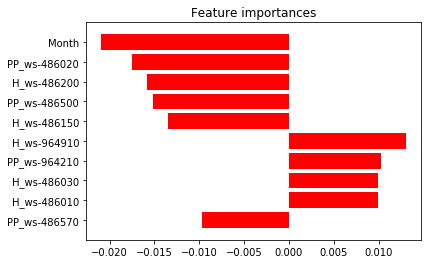

In [67]:
indices = np.argsort(np.abs(r.importances_mean))[-10:]
plt.figure()
plt.title("Feature importances")
plt.barh(range(10), r.importances_mean[indices], color="r", align="center")
plt.yticks(range(10), X.columns[indices])
plt.ylim([-1, 10])
plt.show()